In [5]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.insert(0, "../src")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
from camera import (
    move_camera_pos,
    get_model_state,
    get_camera_info,
    get_camera_image_rgb,
    get_camera_image_depth,
)
import numpy as np
import matplotlib.pyplot as plt
import cv2
import rospy

rospy.init_node("camera_test")

# current default as of 2023-01-18
move_camera_pos(-2, 0, 1, pitch=0.2)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(get_camera_image_rgb())
ax[1].imshow(get_camera_image_depth())
plt.show()

[WARN] [1674196342.917846, 4567.129000]: wait_for_service(/gazebo/set_model_state): failed to contact, will keep trying


KeyboardInterrupt: 

In [62]:
# NOTE: if we try to get the corners using the default perspective, we fail
move_camera_pos(-2, 0, 1, pitch=0.2)
rgb = get_camera_image_rgb()
gray = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (4, 4), None)
ret, corners

(True,
 array([[[236.48392 , 125.914116]],
 
        [[295.48065 , 125.94379 ]],
 
        [[354.03473 , 125.97441 ]],
 
        [[412.4346  , 125.95717 ]],
 
        [[229.4607  , 166.41345 ]],
 
        [[293.41403 , 166.31343 ]],
 
        [[356.60217 , 166.3118  ]],
 
        [[420.47473 , 166.45085 ]],
 
        [[221.50012 , 213.52577 ]],
 
        [[290.4571  , 213.53435 ]],
 
        [[360.48184 , 213.5347  ]],
 
        [[429.7235  , 213.58124 ]],
 
        [[211.02536 , 271.44293 ]],
 
        [[287.56384 , 271.43555 ]],
 
        [[364.49652 , 271.48138 ]],
 
        [[441.57462 , 271.48056 ]]], dtype=float32))

So it turns out that there are some weird things to consider when using `cv2.findChessboardCorners()`.

- https://stackoverflow.com/questions/17665912/findchessboardcorners-fails-for-calibration-image
- https://stackoverflow.com/questions/19190484/what-is-the-opencv-findchessboardcorners-convention

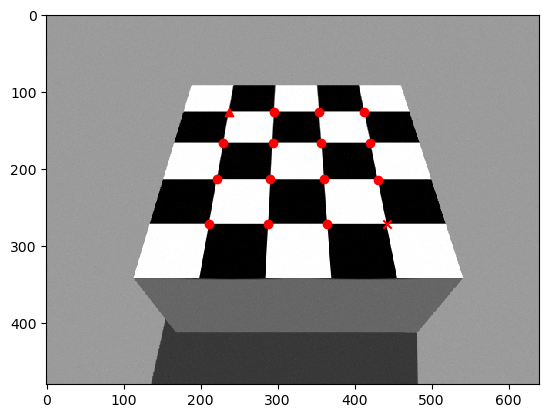

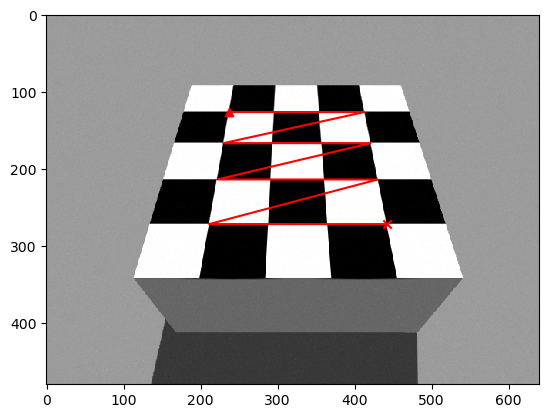

(16, 2)

In [61]:
move_camera_pos(-1, 0, 1.5, pitch=0.9)
rgb = get_camera_image_rgb()

# let's try to get the chessboard corners
gray = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (4, 4), None)
# delete axis 1
corners = corners.squeeze(1)

# we found corners, so let's just draw them using a scatter plot
plt.imshow(rgb)
plt.scatter(corners[1:-1, 0], corners[1:-1, 1], c="r")
plt.scatter(corners[0, 0], corners[0, 1], c="r", marker="^")
plt.scatter(corners[-1, 0], corners[-1, 1], c="r", marker="x")
plt.show()

plt.imshow(rgb)
plt.scatter(corners[0, 0], corners[0, 1], c="r", marker="^")
plt.scatter(corners[-1, 0], corners[-1, 1], c="r", marker="x")
plt.plot(corners[:, 0], corners[:, 1], c="r")
plt.show()

corners.shape

Let's perform DLT with this data now and see what we get.
The the top left corner will be our origin.
In order to recover the depth, we'll need to map the pixel coordinate to the depth image.
We'll use a simple linear interpolation to do this.

In [65]:
# TODO: add depth information
corners

array([[[236.48392 , 125.914116]],

       [[295.48065 , 125.94379 ]],

       [[354.03473 , 125.97441 ]],

       [[412.4346  , 125.95717 ]],

       [[229.4607  , 166.41345 ]],

       [[293.41403 , 166.31343 ]],

       [[356.60217 , 166.3118  ]],

       [[420.47473 , 166.45085 ]],

       [[221.50012 , 213.52577 ]],

       [[290.4571  , 213.53435 ]],

       [[360.48184 , 213.5347  ]],

       [[429.7235  , 213.58124 ]],

       [[211.02536 , 271.44293 ]],

       [[287.56384 , 271.43555 ]],

       [[364.49652 , 271.48138 ]],

       [[441.57462 , 271.48056 ]]], dtype=float32)

In [37]:
# assign each point in a 4x4 grid a value between 0 and 100
points = []
n_grid = 4
height = 0.5
length = 1 / n_grid
for j in range(n_grid):
    for i in range(n_grid):
        points.append((i * length, j * length, height))
points = np.array(points)
points.shape

(16, 3)

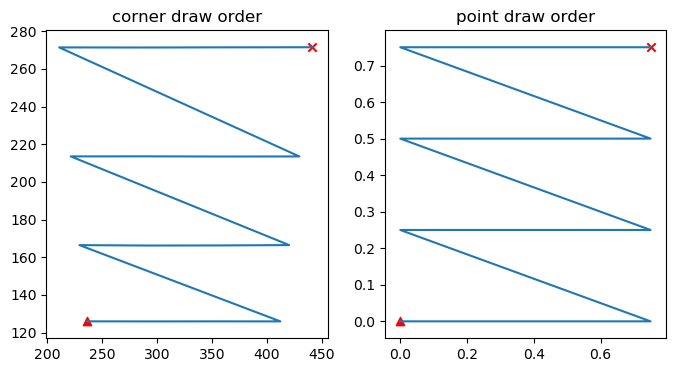

In [38]:
# 1x2 plot
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

x = corners
ax[0].plot(x[:, 0], x[:, 1])
ax[0].scatter(x[0, 0], x[0, 1], c="r", marker="^")
ax[0].scatter(x[-1, 0], x[-1, 1], c="r", marker="x")
ax[0].set_title("corner draw order")

x = points
ax[1].plot(x[:, 0], x[:, 1])
ax[1].scatter(x[0, 0], x[0, 1], c="r", marker="^")
ax[1].scatter(x[-1, 0], x[-1, 1], c="r", marker="x")
ax[1].set_title("point draw order")
plt.show()

In [13]:
# now let's form the A matrix for the DLT
corners.shape

(16, 2)

We use the following equation to map the points.

- https://pvela.gatech.edu/classes/lib/exe/fetch.php?media=ece4580:bali_3d_reconstruction_using_dlt.pdf
- https://pvela.gatech.edu/classes/lib/exe/fetch.php?media=ece4580:ece4580_t03_calibration.pdf

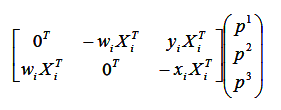

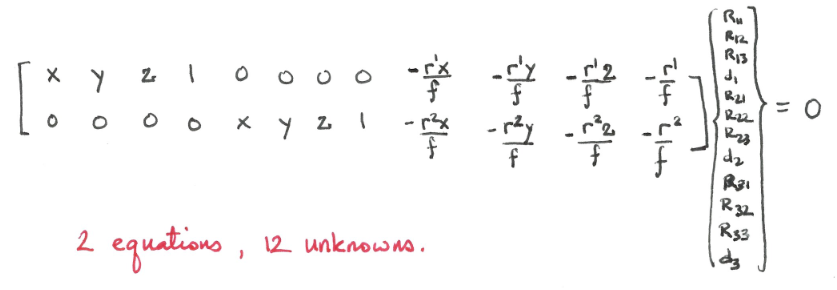

We'll do this the brute force way first, and then figure out how to vectorize it later.

In [54]:
A = []
for corner, point in zip(corners, points):
    x, y = corner
    w = 1
    X = np.hstack([point, 1])
    A += [
        np.hstack([np.zeros(4), -w * X, y * X]),
        np.hstack([w * X, np.zeros(4), -x * X]),
    ]

A = np.array(A)
print(A.shape)

# perform SVD, and get the last right singular vector as the projection matrix
U, s, V = np.linalg.svd(A)
P = V[-1].reshape(3, 4)
P

(32, 12)


array([[-1.92614597e-14, -5.50450432e-15, -1.06748237e-01,
         5.33741185e-02],
       [-9.70577785e-16, -3.27201374e-15,  8.87762883e-01,
        -4.43881442e-01],
       [-3.22669584e-17, -9.29109301e-18,  2.19516886e-02,
        -1.09758443e-02]])